   Test script to load in CESM model prediction of sea ice and regrid to a polar stereo projection

In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
# import glob
import seaborn as sns

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Data dir
data_dir = r'/home/disk/sipn/nicway/data/model/CESM'
cfile = 'wint3mNH.cice.h.1980-01.nc'
file_in = os.path.join(data_dir, cfile)

In [4]:
# Open Data
ds = xr.open_dataset(file_in, decode_times=False)

In [5]:
# Rename lat and long
ds.rename({'TLAT':'lat', 'TLON':'lon'}, inplace=True);

In [51]:
import scipy

In [71]:
lon_b = ds.ULON.values
print(lon_b.shape)
r = lon_b[:,-1]
b = lon_b[-1,]
print(t.shape)
lon_b = np.column_stack((t, lon_b))
lon_b = np.column_stack((t, lon_b))

print(lon_b.shape)

(384, 320)
(384,)
(384, 321)


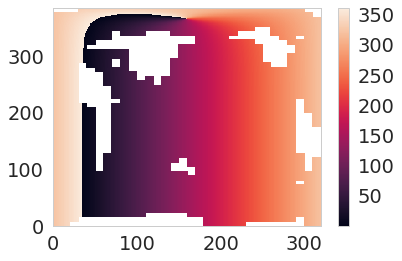

In [69]:
plt.pcolormesh(ds.ULON.values)
plt.colorbar()

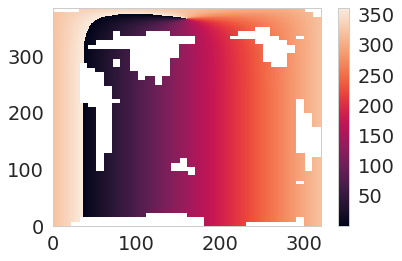

In [70]:
plt.pcolormesh(lon_b)
plt.colorbar()

In [8]:
# olat = ulat[:,1]
# olat.reshape(384,1).shape

In [9]:
# np.hstack((olat, ulat))

In [10]:
# ds.latu_bounds.isel(nj=10, ni=10)

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


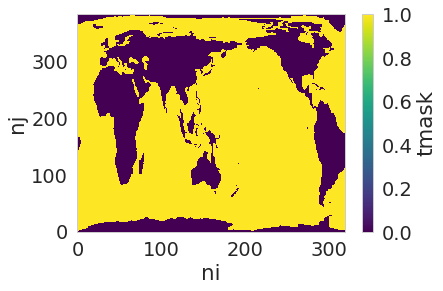

In [12]:
# Select variable of interested (xesmf needs a DataArray)
aice = ds.aice
o_msk = ds.tmask==1
o_msk.plot()

In [13]:
assert((aice.notnull()==o_msk).sum()/o_msk.size==1)

In [15]:
# Get info about target grid
flat = r'/home/disk/sipn/nicway/data/grids/psn25lats_v3.dat'
flon = r'/home/disk/sipn/nicway/data/grids/psn25lons_v3.dat'
NY=304; 
NX=448;

def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))

In [16]:
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_out = xr.Dataset({'lat': (['x', 'y'],  lat), 'lon': (['x', 'y'], lon)})
ds_out

<xarray.Dataset>
Dimensions:  (x: 304, y: 448)
Dimensions without coordinates: x, y
Data variables:
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...

In [34]:
# Calculate regridding matrix
regridder = xe.Regridder(aice, ds_out, 'bilinear', periodic=True)
regridder_msk = xe.Regridder(o_msk, ds_out, 'nearest_s2d', periodic=True)

# Regrid
aice_out = regridder(aice)
o_msk_out = regridder_msk(o_msk)
# sic_out

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_384x320_304x448_peri.nc 
 You can set reuse_weights=True to save computing time.


/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Create weight file: nearest_s2d_384x320_304x448_peri.nc


In [22]:
# Mask out variables with mask
aice_out = aice_out.where(o_msk_out)

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [ ]:
# # Define naive_fast that searches for the nearest WRF grid cell center
# def naive_fast(latvar,lonvar,lat0,lon0):
#     # Read latitude and longitude from file into numpy arrays
#     latvals = latvar[:]
#     lonvals = lonvar[:]
#     dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
#     minindex_flattened = dist_sq.argmin()  # 1D index of min element
#     iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
#     return iy_min,ix_min

In [ ]:
# Testing point selectoin method
# rnd_pts = list(zip(list(np.linspace(sic_out.lat.min().values,sic_out.lat.max().values,50)),
#                    list(np.linspace(sic_out.lon.min().values,sic_out.lon.max().values,50))))
# lat_err = []
# lon_err = []
# for cpt in rnd_pts:
# #     print(cpt)
#     (c_y, c_x) = naive_fast(sic_out.lat.values, sic_out.lon.values, cpt[0], cpt[1])
# #     print(sic_out.isel(x=c_x, y=c_y).lat.values, cpt[0])
# #     print(sic_out.isel(x=c_x, y=c_y).lon.values, cpt[1])
#     lat_err.append((sic_out.isel(x=c_x, y=c_y).lat-cpt[0]).values)
#     lon_err.append((sic_out.isel(x=c_x, y=c_y).lon-cpt[1]).values)
# plt.figure()
# plt.plot(np.linspace(sic_out.lat.min().values,sic_out.lat.max().values,50), lat_err)
# plt.figure()
# plt.plot(np.linspace(sic_out.lon.min().values,sic_out.lon.max().values,50), lon_err)

In [ ]:
# # Test Regridding was successful
# pt_lon = 0
# pt_lat = 72
# (c_y, c_x) = naive_fast(sic_out.lat.values, sic_out.lon.values, pt_lat, pt_lon)
# plt.figure()
# sic.sel(lon=pt_lon, lat=pt_lat, method='nearest').plot(linewidth=3, label='orig projection')  # input data
# sic_out.sel(x=c_x, y=c_y).plot(label='new projection')# output data
# plt.legend()

In [24]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')

In [ ]:
aice

Text(0,0.5,'lat')

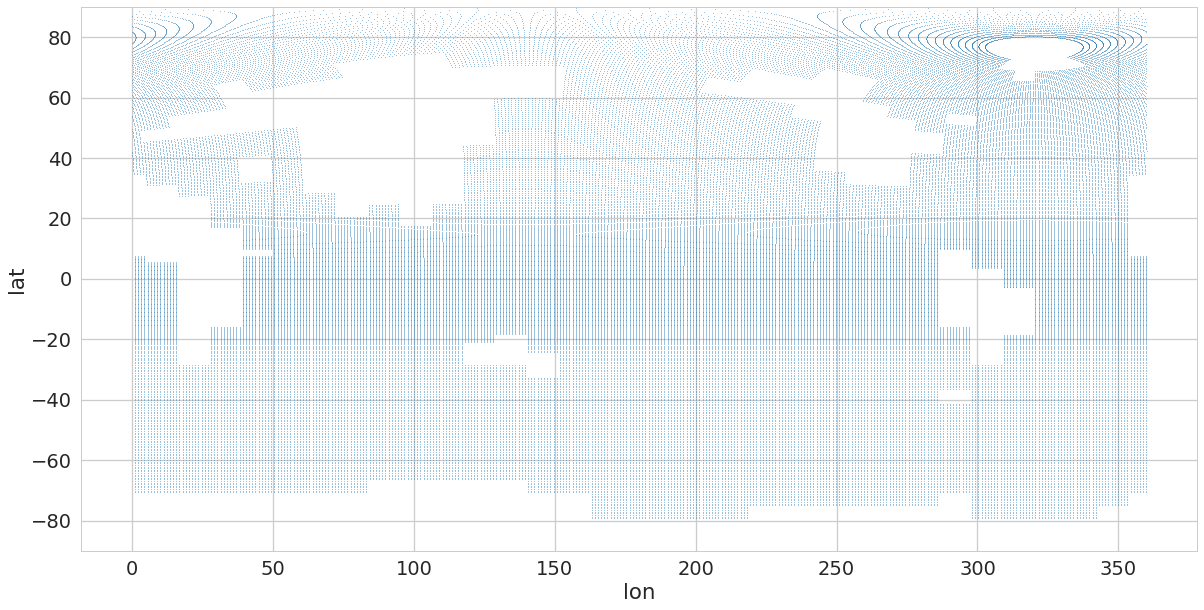

In [25]:
# Plot the input Grid
plt.figure(figsize=(20,10))
plt.scatter(aice['lon'], aice['lat'], s=0.1)  # plot grid locations
plt.ylim([-90, 90])
plt.xlabel('lon')
plt.ylabel('lat')

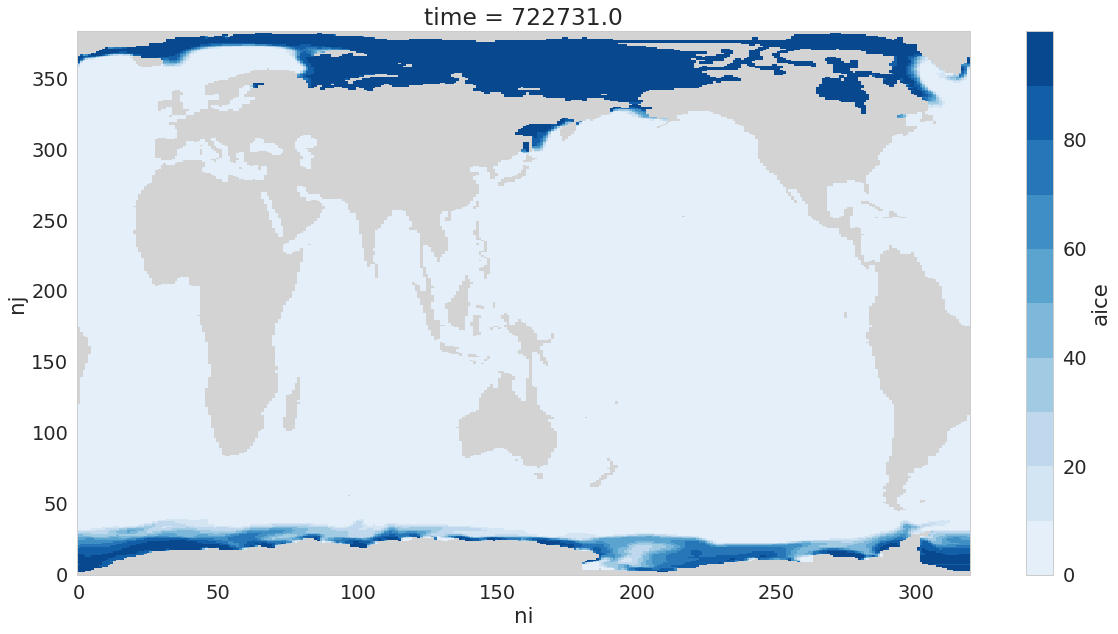

In [26]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes()
aice.isel(time=0).plot.pcolormesh(ax=ax1, x='ni', y='nj', 
                                 vmin=aice.min().values, vmax=aice.max().values,
                                 cmap=cmap_sic);

In [27]:
# (cartopy can't handel non-continuous grids using pcolormesh....)
#
# # Plot original projection 
# plt.figure(figsize=(20,10))
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# aice.isel(time=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                  vmin=aice.min().values, vmax=aice.max().values,
#                                  cmap=cmap_sic);
# ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

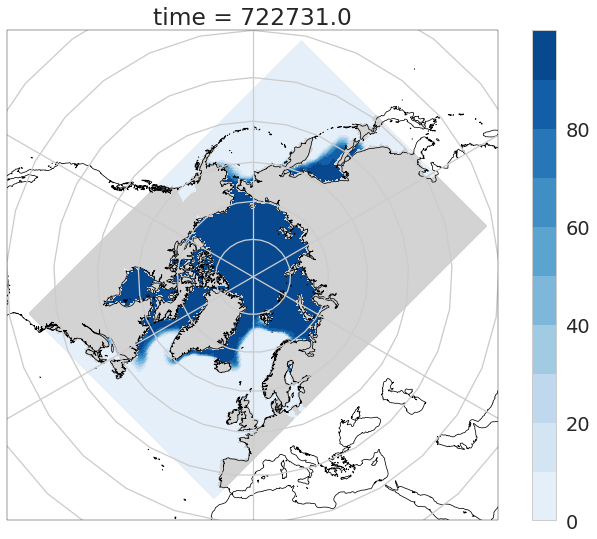

In [30]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
aice_out.isel(time=0).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

In [31]:
# # Save new file
# f_out = os.path.join(data_dir, os.path.splitext(cfile)[0]+'_Stereo.nc')
# sic_out.to_netcdf(f_out)

In [32]:
# Clean up
regridder.clean_weight_file()  # clean-up

Remove file bilinear_384x320_304x448_peri.nc
